In [1]:
# Carrie Lei & Diana Cantini
# Final Project: Phased Array Antenna Simulation

# Milestone 2 Goal: phase shifted input current sources; writing a better function to easily simulate multiple antennas in a row; NTFF transformations
# To be implemented next: 

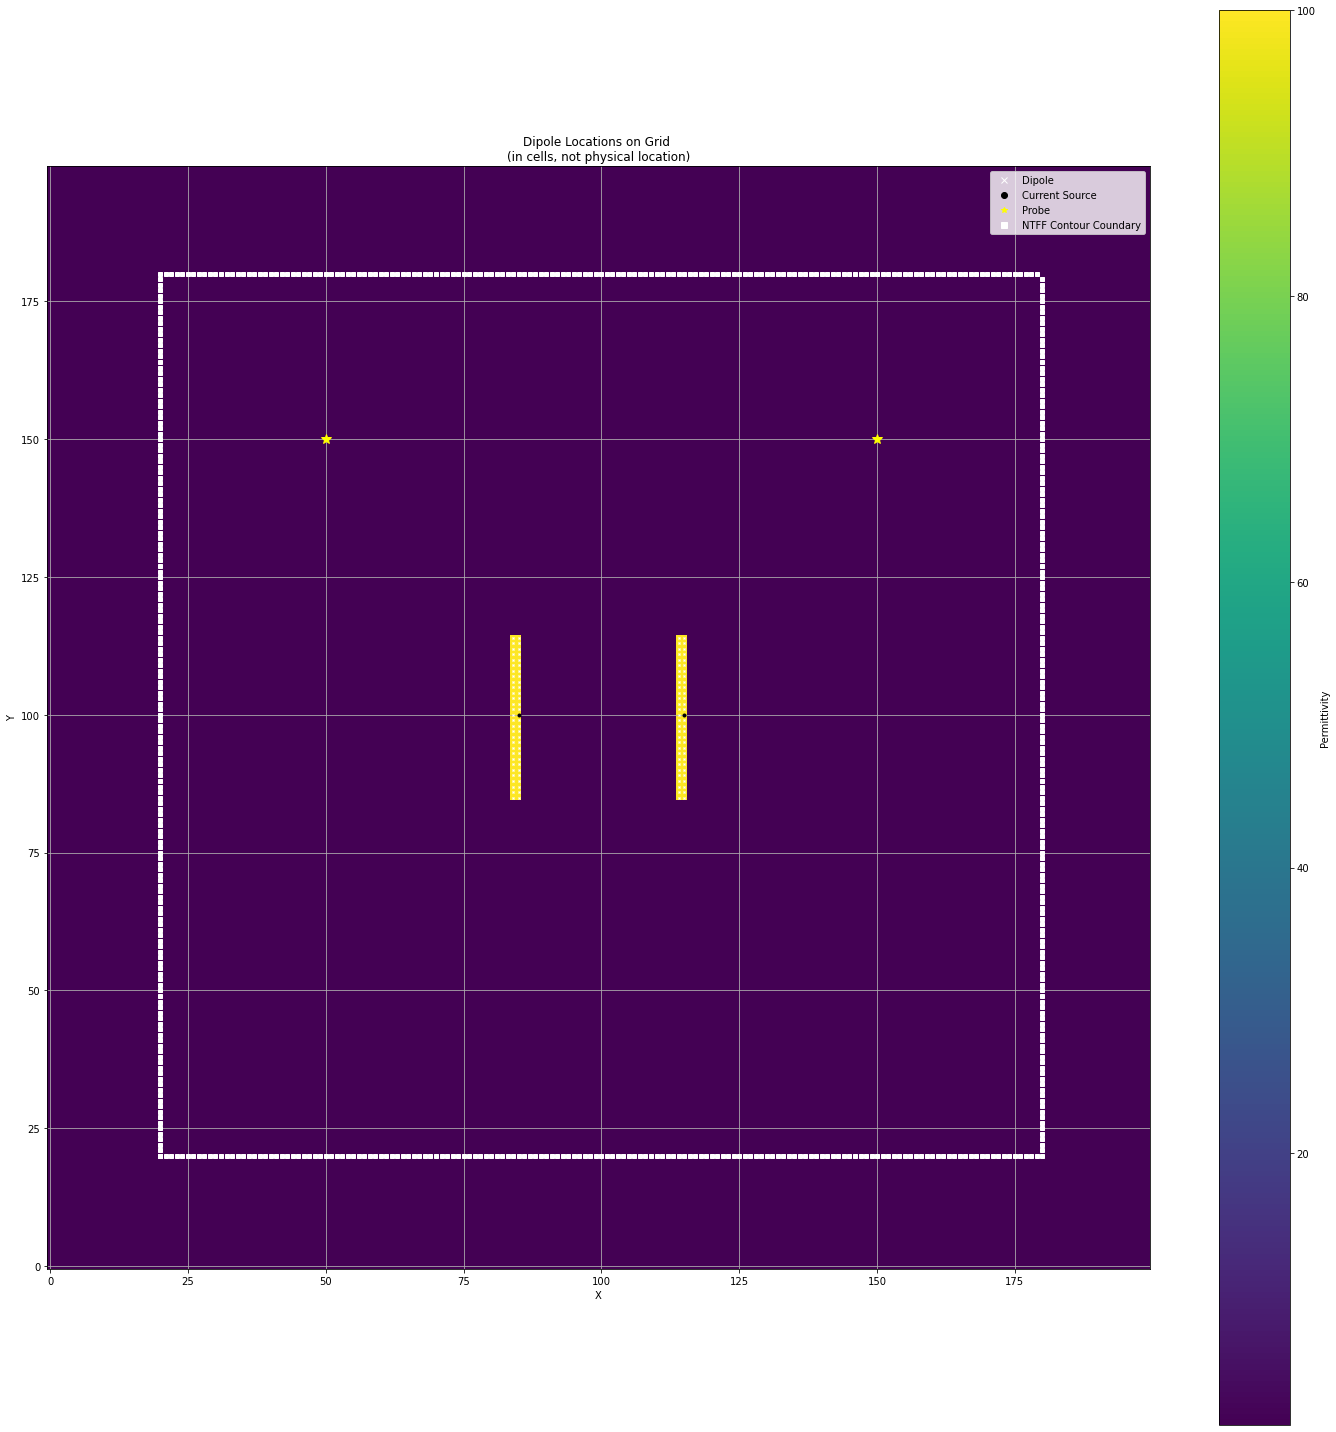

In [2]:
# streamlined function to simulate 1xn antennas

import matplotlib.pyplot as plt
import math
import numpy as np

# Simulation Parameters
e0 = 1        
mu0 = 1       
c0 = 1 / math.sqrt(e0 * mu0) 
dx = 0.5e-3 # unit cell is 0.5mm x 0.5mm
dy = 0.5e-3 
magic_time_step = dx / (np.sqrt(2) * c0)
max_time_steps = 400

# Grid in cell units
whole_grid = 100e-3 # whole grid = 200 mm
numX_cells = int(whole_grid / dx)  
numY_cells = int(whole_grid / dy)   
center_x = numX_cells // 2 # find center points
center_y = numY_cells // 2

# Set up the permittivity grid 
grid = np.ones((numY_cells, numX_cells)) * e0

# Source parameters
lambda0 = 6e-2 # wavelength for 5G is 6 cm
lambda_lower = 5e-2
lambda_upper = 7e-2
omega0 = (2 * np.pi * c0) / lambda0
sigma = (2 / omega0) * (lambda0 / (lambda_upper - lambda_lower))

# Arrays to store fields
Ez = np.zeros((numX_cells, numY_cells))
Hx = np.zeros((numX_cells, numY_cells))
Hy = np.zeros((numX_cells, numY_cells))

# Dipole Parameters
numberAntennas = 2
dipole_epsilon = 100
dipole_spacing_cells = int(15e-3 / dx) # space between dipoles = 15mm = 30 cells
dipole_width = 1e-3 # dipole thickness = 1 mm
dipole_height = 15e-3 # dipole height = 15 mm
dipole_width_cells = int(dipole_width / dx)         
dipole_height_cells = int(dipole_height / dy)  

# Probe locations
probe_beam_direction_x = int(numX_cells *.75) # this probe is put at the angle of target beam (45 degrees from x axis)
probe_beam_direction_y = int(numY_cells * .75)
probe_x = int(numX_cells * .25) # this probe is put far away from target angle (135 from x axis)
probe_y = int(numY_cells *.75)
Ez_probe_beam = np.zeros(max_time_steps) # store values at probes
Ez_probe = np.zeros(max_time_steps)



# NTFF Parameters ----------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Compute phasor E and M fields on closed contour boundary
# defining square boundary form L1 --> L4
line_size = whole_grid - 20e-3 # lines form a boundary 10mm inside of whole grid size
numL_cells = int(line_size // dx) #numL cells is length of closed countour boundary in cell units

L_starting_dim= 10e-3 #starting index for L2, L4
L_starting_cell_idx = int(L_starting_dim //dx)
L_ending_dim= numX_cells - numL_cells
L_ending_cell_idx=L_starting_cell_idx + numL_cells

#L1 is vertical, RHS line
L1_col1 = np.full(numL_cells, L_ending_cell_idx)
L1_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)

L1_idxs = np.column_stack((L1_col1,L1_col2))

#L2 is vertical, LHS line
L2_col1=np.full(numL_cells,L_starting_cell_idx)
L2_col2=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L2_idxs=np.column_stack((L2_col1,L2_col2))

#L3 is horizontal, top line
L3_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L3_col2=np.full(numL_cells, L_ending_cell_idx)
L3_idxs=np.column_stack((L3_col1,L3_col2))

#L4 is horizontal, bottom line
L4_col1=np.arange(L_starting_cell_idx, L_ending_cell_idx)
L4_col2=np.full(numL_cells, L_starting_cell_idx)
L4_idxs=np.column_stack((L4_col1,L4_col2))

#print(L1_idxs)


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Current source vectors
sources = []

def placeAndVisualizeAntennas(numAntennas, spacingBetween, dipoleLength, dipoleWidth, grid, e_dipole):

    # find where the centers of each dipole would be
    centers = []

    if (numAntennas %2) == 1: # for odd number of antennas, the middle one is at center of grid
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2) *spacingBetween
            centers.append(leftPoint + (i*spacingBetween))

    else: # for an even number of antennas, the middle point of grid is between two antennas
        spaceFromCenter = spacingBetween // 2
        for i in range(numAntennas):
            leftPoint = center_x - (numAntennas //2 -1) *spacingBetween - spaceFromCenter
            centers.append(leftPoint + (i*spacingBetween))

    # Visualize everything
    plt.figure(figsize=(20, 20))

    # Find dimensions of antenna on the grid
    for x in centers:
        x_center = x
        x_left = x_center - (dipoleWidth // 2)
        x_right = x_left + dipoleWidth - 1
        x_bottom = center_y - (dipoleLength // 2)
        x_top = x_bottom + dipoleLength - 1

        # place antennas on permittivity grid
        for y in range(x_left, x_right + 1):
            for z in range(x_bottom, x_top + 1):
                grid[z, y] = e_dipole
                plt.plot(y, z, 'x', markersize = 2, color='white')

        sources.append((x, center_y))
    
    # Show where the sources are injected on grid
    for location in sources:
        plt.plot(location[0], location[1], 'o', markersize = 3, color = 'black')
    
    # Show where the probes are on the grid
    plt.plot(probe_beam_direction_x, probe_beam_direction_y, '*', markersize = 10, color = 'yellow')
    plt.plot(probe_x, probe_y, '*', markersize = 10, color = 'yellow')

    #Adding (x,y) pairs from L1, shown as white
    all_line_idx=[L1_idxs,L2_idxs,L3_idxs,L4_idxs]
    for j in all_line_idx:
        for x, y in j:
            plt.plot(x,y, 's',markersize = 4, color = 'white')
    
    # Plot the permittivity grid
    plt.imshow(grid, cmap='viridis', origin= 'lower')
    plt.colorbar(label='Permittivity')

    # Add the legend
    plt.plot([], [], 'x', color = 'white', label = 'Dipole')
    plt.plot([], [], 'o', color = 'black', label = 'Current Source')
    plt.plot([], [], '*', color = 'yellow', label = 'Probe')
    plt.plot([], [], 's', color ='white', label = 'NTFF Contour Coundary')
    plt.legend(loc='upper right', fontsize = 'medium')

    plt.title('Dipole Locations on Grid \n(in cells, not physical location)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.grid()
    plt.show()

placeAndVisualizeAntennas(numberAntennas, dipole_spacing_cells, dipole_height_cells, dipole_width_cells, grid, dipole_epsilon)

In [3]:
# Beam steering using phase delays 

print(sources)

theta0 = 45 # target beam from z axis
phi0 = 45 # target beam from x axis

k = (np.pi * 2 / lambda0)
kx = k * np.sin(np.radians(theta0)) * np.cos(np.radians(phi0))
ky = k * np.sin(np.radians(theta0)) * np.sin(np.radians(phi0))

phasedSources = []

for location in sources:
    # convert location to physical location in mm (not num cells)
    phase = -(kx*location[0]*dx + ky*location[1]*dy) # in radians
    phasedSources.append((location[0], location[1], phase))

print(phasedSources) 

[(85, 100), (115, 100)]
[(85, 100, -4.843288674284265), (115, 100, -5.628686837681714)]


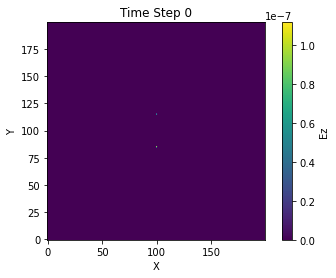

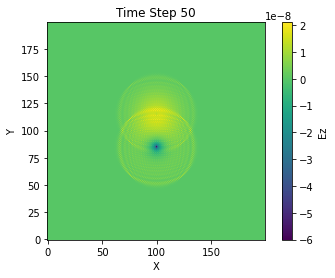

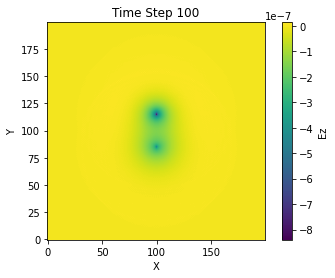

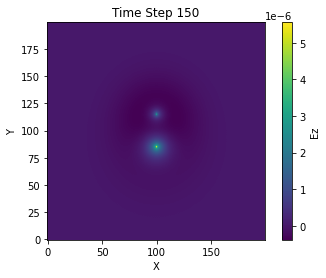

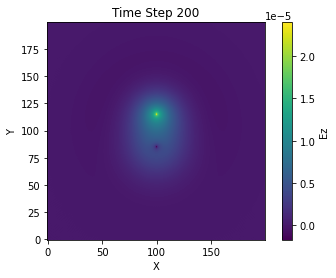

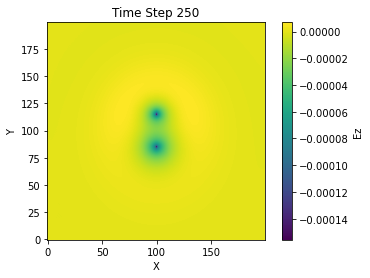

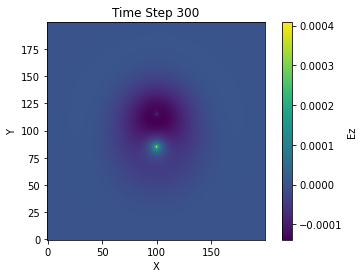

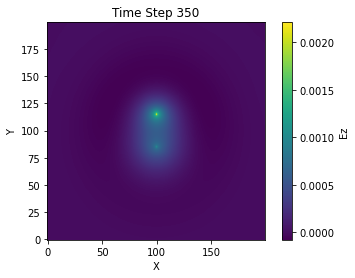

In [5]:
# 2D FDTD Model

# Using absorbing boundary condition to simulate the energy being absorbed in air.
boundaryLeft = np.zeros(numY_cells)
boundaryRight = np.zeros(numY_cells)
boundaryBottom = np.zeros(numX_cells)
boundaryTop = np.zeros(numX_cells)


# Defining Ez_time_L1 (right hand side line)
Ez_time_L1 = np.zeros((numL_cells, max_time_steps))
Hx_time_L1 = np.zeros((numL_cells, max_time_steps))
Hy_time_L1 = np.zeros((numL_cells, max_time_steps))


# Main 2D FDTD Loop
for n in range(max_time_steps):

    # Compute Hy 
    for i in range(numX_cells - 1):
        for j in range(numY_cells):
            Hy[i, j] += (Ez[i + 1, j] - Ez[i, j]) * magic_time_step / dx

            match = np.any((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))
            if match==True:
                idx = np.where((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))[0]
                Hy_time_L1[idx,n] = (Ez[i,j] + Ez[i,j-1]) /2 # Collocate values on boundary

     # Compute Hx
    for i in range(numX_cells):
        for j in range(numY_cells - 1):
            Hx[i, j] -= (Ez[i, j + 1] - Ez[i, j]) * magic_time_step / dy

            match = np.any((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))
            if match==True:
                idx = np.where((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))[0]
                Hx_time_L1[idx,n]= (Ez[i,j] + Ez[i-1, j]) /2 # Collocate values on boundary


    # Use temp variables to store left and bottom Ez values sorta like a moving window; only 2 sides needed bc symmetrical
    tempLeft = Ez[1, :].copy() 
    tempBottom = Ez[:, 1].copy()  

    # Compute Ez ---------------------------------------------------------------------------- Wouldn't we have to update Ez_time_L1 using the Hx and Hy_time_l1 variables?
    for i in range(1, numX_cells - 1):
        for j in range(1, numY_cells - 1):
            Ez[i, j] += ((Hy[i, j] - Hy[i - 1, j]) * magic_time_step / dx) - ((Hx[i, j] - Hx[i, j - 1]) * magic_time_step / dy)

            #recording Ez at L1
            match = np.any((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))
            if match==True:
                idx = np.where((L1_idxs[:, 0] == i) & (L1_idxs[:, 1] == j))[0]
                Ez_time_L1[idx,n]=Ez[i,j]

    
    # Store Ez at probes
    Ez_probe_beam[n] = np.abs(Ez[probe_beam_direction_x, probe_beam_direction_y])
    Ez_probe[n] = np.abs(Ez[probe_x, probe_y])

    # Apply excitation at antenna sources
    t_n = n * magic_time_step
    for (x_coord, y_coord, phase) in phasedSources:
        Ez[x_coord, y_coord] += np.exp(-((t_n - 4 * sigma) ** 2) / sigma ** 2) * np.sin(omega0 * t_n + phase)

    # Update absorbing conditions
    Ez[0, :] = boundaryLeft
    Ez[-1, :] = boundaryRight
    Ez[:, 0] = boundaryBottom
    Ez[:, -1] = boundaryTop

    # Update boundary buffers for next time step
    boundaryLeft = tempLeft
    boundaryBottom = tempBottom
    boundaryRight = Ez[-2, :].copy()
    boundaryTop   = Ez[:, -2].copy()
    
    # Visualize Ez field every 50 time steps
    if n % 50 == 0:
        plt.clf() 
        plt.imshow(Ez, cmap='viridis', origin='lower')
        plt.title(f"Time Step {n}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.colorbar(label="Ez")
        plt.pause(0.01) 

plt.show()

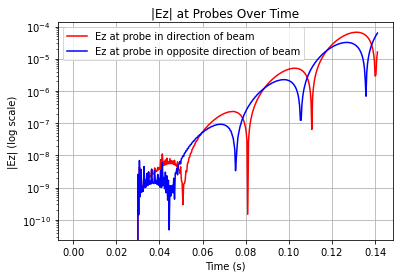

In [6]:
# Plot Ez at the probe in direction of beam over time in comparison to probe at opposite direction; shows the 45 degrees out of phase with each other
time_steps = np.arange(max_time_steps)*magic_time_step
plt.semilogy(time_steps, Ez_probe_beam, label='Ez at probe in direction of beam', color = 'red')
plt.semilogy(time_steps, Ez_probe, label='Ez at probe in opposite direction of beam', color = 'blue')
plt.xlabel('Time (s)')
plt.ylabel('|Ez| (log scale)')
plt.title('|Ez| at Probes Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Calculate gain difference between probes
power_off = np.sum(Ez_probe ** 2)
power_beam = np.sum(Ez_probe_beam ** 2)
gain_dB = 10 * np.log10(power_beam / power_off)
gain_dB # which means the probe at direction of beam had about 2.5 times increase in power

4.451331277878486

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.94023003e-05, -2.05358956e-05, -2.16972887e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.06706016e-05, -2.18277391e-05, -2.30131981e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.19507747e-05, -2.31466028e-05, -2.43476047e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.20008633e-05, -2.32164037e-05, -2.44498809e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.06907140e-05, -2.18841999e-05, -2.30982987e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.94042074e-05, -2.05743961e-05, -2.17660903e-05]])

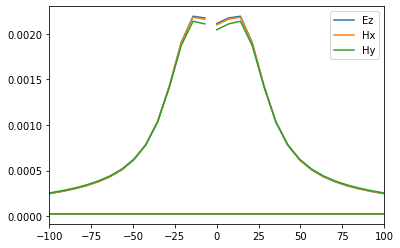

In [10]:
display(Ez_time_L1)

#perform DFT on each row in Ez_time_L1 matrix
#taking fft of each spatial element
Ez_L1_fft_vals=np.fft.fft(Ez_time_L1, axis=1)
Ez_L1_freqs=np.fft.fftfreq(max_time_steps, d = magic_time_step)

Hx_L1_fft_vals=np.fft.fft(Hx_time_L1, axis=1)
Hx_L1_freqs=np.fft.fftfreq(max_time_steps, d = magic_time_step)

Hy_L1_fft_vals=np.fft.fft(Hy_time_L1, axis=1)
Hy_L1_freqs=np.fft.fftfreq(max_time_steps, d = magic_time_step)

#sample plot:
plt.figure()
plt.plot(Ez_L1_freqs,np.abs(Ez_L1_fft_vals[50]), label = 'Ez')
plt.plot(Hx_L1_freqs,np.abs(Hx_L1_fft_vals[50]), label = 'Hx')
plt.plot(Hy_L1_freqs,np.abs(Hy_L1_fft_vals[50]), label = 'Hy')
plt.legend()
plt.xlim([-100,100])
plt.show()

In [ ]:
#compute Jeq and Meq

#along L1, Meq = Ez(phasor)

#first: extract phasor element at 16.66 MHz
target_freq= omega0/(2*np.pi)
bin_idx = np.argmin(np.abs(Ez_L1_freqs - target_freq))

Meq_L1_phasors = Ez_L1_fft_vals[:,bin_idx]
Jeq_L1_phasors=Hy_L1_fft_vals[:,bin_idx]

print(Meq_L1_phasors)

[-0.00027934+8.41642069e-05j -0.00030613+7.59054837e-05j
 -0.00033389+6.67020909e-05j -0.00036261+5.65279280e-05j
 -0.00039226+4.53590205e-05j -0.00042281+3.31731213e-05j
 -0.00045425+1.99505098e-05j -0.00048651+5.67405870e-06j
 -0.00051957-9.67095795e-06j -0.00055339-2.60967276e-05j
 -0.00058791-4.36122156e-05j -0.00062308-6.22235119e-05j
 -0.00065883-8.19339453e-05j -0.00069513-1.02743373e-04j
 -0.00073189-1.24648236e-04j -0.00076903-1.47641969e-04j
 -0.00080652-1.71714579e-04j -0.00084425-1.96852140e-04j
 -0.00088215-2.23037638e-04j -0.00092014-2.50250533e-04j
 -0.00095815-2.78466495e-04j -0.00099608-3.07657564e-04j
 -0.00103385-3.37792734e-04j -0.00107139-3.68837201e-04j
 -0.00110859-4.00752570e-04j -0.00114536-4.33497486e-04j
 -0.00118164-4.67027415e-04j -0.00121733-5.01294231e-04j
 -0.00125233-5.36247174e-04j -0.00128658-5.71832902e-04j
 -0.00132   -6.07995013e-04j -0.00135249-6.44674683e-04j
 -0.00138399-6.81811277e-04j -0.00141444-7.19341880e-04j
 -0.00144374-7.57201577e-04j -0

[-1.         -0.99949987 -0.99899975 ...  0.99899975  0.99949987
  1.        ]
[ 0.35249394-0.10683619j  0.35916901-0.09152207j  0.36515779-0.07581976j
 ... -0.22523363+0.23346272j -0.23345147+0.22133841j
 -0.24102846+0.20893904j]


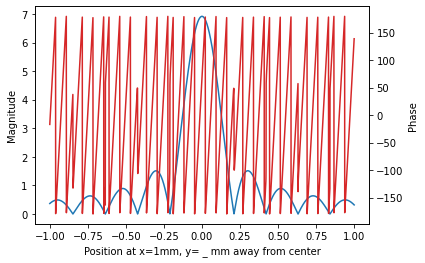

In [16]:
#Above code deals with calcualting E in far field for only one point in space.
#To better visualize far field effects, need to evaluate Ez in far field across some line.

#copying from existing code block, looping to create matrix of e^jkr hat r bar prime factors
#defining r_bar position in far field: 

#This implementation is incorrect. First, we do not want to implement for some point r at some fixed distance, because we want to take distance to infinity.
#therefore, calculate scattering width, which computes power radiated within a theta cross section
#should be plotted as a function of theta

r_bar_x = 1000e-3 # x distance from center is 1000mm away: 1 m away
r_bar_y_min = -1000e-3
r_bar_y_max = 1000e-3
center_sim_x_y=np.array([center_x,center_y])

#far field will be evaluated from, in x,y: 1m, -1m --> 1m, 1m: essentially vertical line to the right of simulation
num_ff_pts=int(abs((r_bar_y_max-r_bar_y_min)/dy))
r_bar_y_min_to_max_arr=np.linspace(r_bar_y_min,r_bar_y_max,num=num_ff_pts)

Ez_far_field_arr=np.zeros(num_ff_pts,dtype=np.complex128)

for i in range (0,num_ff_pts):

    r_bar_x_y=np.array([r_bar_x,r_bar_y_min_to_max_arr[i]])

    r_hat_dot_r_prime_bar=np.zeros(numL_cells)
    
    #calculate magnitude using built in function
    r_bar_magnitude= np.linalg.norm(r_bar_x_y - center_sim_x_y)
    #print(r_bar_magnitude)
    
    #define unit vector r hat from given r bar positions
    r_hat_x_y=np.array([r_bar_x/r_bar_magnitude , r_bar_y_min_to_max_arr[i]/r_bar_magnitude])

    #near field source point vector
    #as of now: only from pts on L1
    r_bar_prime_x=(np.linspace(L_ending_dim,L_ending_dim,numL_cells)) - (center_x*dx)
    r_bar_prime_y=(np.linspace(L_starting_dim,L_ending_dim,numL_cells)) - (center_y*dy)
    r_bar_prime_x_y=np.array([r_bar_prime_x,r_bar_prime_y])


    #element wise dot product from single rbarprime vector (to ff point), and r_hat_x_y points (all points along L1)
    r_hat_dot_r_prime_bar=np.dot(r_hat_x_y,r_bar_prime_x_y)
    #print(r_hat_dot_r_prime_bar)                    

    k = 2 * np.pi / lambda0
    L1_integral = 0+0j
    L1_integral_arr = ( (omega0 * mu0 * np.sum(Jeq_L1_phasors[0:-1])) - (k*Meq_L1_phasors[0:-1]) ) *np.exp(1j * k *r_hat_dot_r_prime_bar[0:-1])

    L1_integral_val=np.sum(L1_integral_arr)

    r=r_bar_magnitude
    far_field_integral_const= (np.exp(-1j*k*r) / math.sqrt(r) ) * ( (np.exp(np.pi * 1j / 4)) / math.sqrt(8*np.pi*k) )

    Ez_far_field_arr[i] = far_field_integral_const * L1_integral_val

print(r_bar_y_min_to_max_arr)
print(Ez_far_field_arr)

#visualizing Ez_far_field_arr
mag=np.abs(Ez_far_field_arr)
phase=np.angle(Ez_far_field_arr)
phase_deg=180*phase/np.pi

fig,ax1=plt.subplots()
ax1.set_xlabel('Position at x=1mm, y= _ mm away from center')
ax1.set_ylabel('Magnitude')
color='tab:blue'
ax1.plot(r_bar_y_min_to_max_arr,mag,color=color)

ax2=ax1.twinx()
ax2.set_ylabel('Phase')
color='tab:red'
ax2.plot(r_bar_y_min_to_max_arr,phase_deg,color=color)
plt.show()  